In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 27.7 MB/s eta 0:00:00


In [1]:
# @title Imports
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.check_data import prepare_time_series
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.calibrate import calibrate_model
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.q_labels_matching import enrich_q_labels_trend_one_side, soft_signal_labels_gaussian
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.visualisation import plot_enriched_actions_one_side
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.dataset_builder import DatasetBuilderForYourColumns
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.residual_lstm import build_stacked_residual_lstm
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.train_eval import fit_model, plot_history_curves, evaluate_dataset, confusion_and_f1_on_dataset, materialize_metrics, predict_logits_dataset
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.backtest_env import BacktestEnv, EnvConfig, run_backtest_with_logits
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.optuna_tuner import optimize_hyperparameters
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.indicators import *
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.filter_trend import get_intervals, plot_price_with_valid

In [2]:
# @title Load and check data

# PATH_TO_DATA = "dummy_df.joblib"  # <-- provide path
PATH_TO_DATA = "/content/drive/MyDrive/stocks/Data/DOGEUSDT/raw_data/DOGEUSDT_1m_2024-01-01_to_2025-05-23.joblib"
START = "2024-01-20"
END = "2025-05-23"
TIMESTAMP_COL = "timestamp"          # column with timestamps

raw_df = joblib.load(PATH_TO_DATA)
df = prepare_time_series(raw_df, timestamp_col=TIMESTAMP_COL).loc[START:END]
print(f"From {df.index[0]} to {df.index[-1]}")

From 2024-01-20 00:00:00+00:00 to 2025-05-23 23:59:00+00:00


In [3]:
# @title Add indicators

# Базовые массивы (создаём один раз)
close  = df['Close'].to_numpy(np.float64)
high   = df['High'].to_numpy(np.float64)
low    = df['Low'].to_numpy(np.float64)
volume = df['Volume'].to_numpy(np.float64)

# Словарь для новых колонок
new_cols = {}
obv_arr = obv_numba(close, volume)

for i in range(35, 246, 7):
    ema_i = ema_numba(close, i)
    sma_i = sma_numba(close, i)
    adx_i = adx_numba(high, low, close, i)
    atr_i = atr_numba(high, low, close, i)
    rsi_i = rsi_numba(close, i)

    fast = i
    slow = i * 2
    sig  = i // 2  # вместо int(i/2)

    macd, macd_signal, macd_hist = macd_numba(close, fast, slow, sig)
    stoch_k, stoch_d = stoch_numba(high, low, close, i, i // 2)
    boll_mid, boll_up, boll_dn = bollinger_numba(close, i, 2.0)
    cci_i  = cci_numba(high, low, close, i)
    willr_i= williams_r_numba(high, low, close, i)
    mfi_i  = mfi_numba(high, low, close, volume, i)
    roc_i  = roc_numba(close, i)
    vwap_i = vwap_numba(high, low, close, volume, i)  # если это rolling VWAP на окне i

    new_cols.update({
        f"EMA_{i}":          ema_i,
        f"SMA_{i}":          sma_i,
        f"ADX_{i}":          adx_i,
        f"ATR_{i}":          atr_i,
        f"RSI_{i}":          rsi_i,
        f"MACD_{i}":         macd,
        f"MACD_signal_{i}":  macd_signal,
        f"MACD_hist_{i}":    macd_hist,
        f"STOCH_K_{i}":      stoch_k,
        f"STOCH_D_{i}":      stoch_d,
        f"BOLL_MID_{i}":     boll_mid,
        f"BOLL_UP_{i}":      boll_up,
        f"BOLL_DN_{i}":      boll_dn,
        f"OBV":              obv_arr,
        f"CCI_{i}":          cci_i,
        f"WILLR_{i}":        willr_i,
        f"MFI_{i}":          mfi_i,
        f"ROC_{i}":          roc_i,
        f"VWAP_{i}":         vwap_i,
    })

# Добавляем все столбцы разом — без фрагментации
df = pd.concat([df, pd.DataFrame(new_cols, index=df.index)], axis=1)

print(df.columns.to_list())

['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'EMA_35', 'SMA_35', 'ADX_35', 'ATR_35', 'RSI_35', 'MACD_35', 'MACD_signal_35', 'MACD_hist_35', 'STOCH_K_35', 'STOCH_D_35', 'BOLL_MID_35', 'BOLL_UP_35', 'BOLL_DN_35', 'OBV', 'CCI_35', 'WILLR_35', 'MFI_35', 'ROC_35', 'VWAP_35', 'EMA_42', 'SMA_42', 'ADX_42', 'ATR_42', 'RSI_42', 'MACD_42', 'MACD_signal_42', 'MACD_hist_42', 'STOCH_K_42', 'STOCH_D_42', 'BOLL_MID_42', 'BOLL_UP_42', 'BOLL_DN_42', 'CCI_42', 'WILLR_42', 'MFI_42', 'ROC_42', 'VWAP_42', 'EMA_49', 'SMA_49', 'ADX_49', 'ATR_49', 'RSI_49', 'MACD_49', 'MACD_signal_49', 'MACD_hist_49', 'STOCH_K_49', 'STOCH_D_49', 'BOLL_MID_49', 'BOLL_UP_49', 'BOLL_DN_49', 'CCI_49', 'WILLR_49', 'MFI_49', 'ROC_49', 'VWAP_49', 'EMA_56', 'SMA_56', 'ADX_56', 'ATR_56', 'RSI_56', 'MACD_56', 'MACD_signal_56', 'MACD_hist_56', 'STOCH_K_56', 'STOCH_D_56', 'BOLL_MID_56', 'BOLL_UP_56', 'BOLL_DN_56', 'CCI_56', 'WILLR_56', 'MFI_56', 'ROC_56', 'VWAP_56', 'EMA_63', 'SMA_63', 'ADX_63', 'ATR_63', 'RSI_63', 'MACD_63', 

In [ ]:
# @title Params optimization (только для подбора)
import optuna
import tensorflow as tf
from optuna import Trial
from typing import Dict, List
from optuna.visualization import plot_pareto_front

LONG_CONFIG = EnvConfig(
    mode=1,          # работаем только от длинной позиции
    fee=0.0002,         # без комиссии
    spread=0.0001,      # без спреда
    leverage=1.0,    # без плеча
    max_steps=10**9, # практически бесконечный эпизод
    reward_scale=1.0,# без масштабирования вознаграждения
    use_log_reward=False, # линейная доходность
    time_penalty=0.0,     # нет штрафа за удержание
    hold_penalty=0.0,     # нет штрафа за бездействие
)

def optimize_ref_strategy_hyperparameters(
    dataframe: pd.DataFrame,
    n_trials: int = 10
) -> Dict[str, object]:

    df = dataframe.copy()

    def objective(trial: Trial) -> float:
        rsi_p = trial.suggest_int("RSI_period", 35, 245, step=7)
        bb_u_p = trial.suggest_int("BBU", 35, 245, step=7)
        bb_d_p = trial.suggest_int("BBD", 35, 245, step=7)
        rsi_trh = trial.suggest_int("RSI_thr", 20, 50, step=1)

        buy_sig  = ((df[f'RSI_{rsi_p}'] <= rsi_trh) & (df['Low'] <= df[f'BOLL_DN_{bb_d_p}']))
        sell_sig = (df['High'] >= df[f'BOLL_UP_{bb_u_p}'])

        df['Signal_Rule'] = np.where(buy_sig, 1, np.where(sell_sig, -1, 0)).astype(np.int8)

        def run_backtest(environment):
            env = environment
            env.reset()
            signals = env.df['Signal_Rule'].to_numpy()
            for sig in signals[:-1]:
                pos = env.position
                if sig == 1:
                    action = 0 # OPEN
                elif sig == -1:
                    action = 1 # CLOSE
                else:
                    action = 2 if pos == 1 else 3 # HOLD or WAIT
                _, _, done, _ = env.step(action)
                if done:
                    break
            return env

        env_ref = BacktestEnv(df, cfg=LONG_CONFIG, price_col='Open', ppo_true=False)
        sim_ref = run_backtest(env_ref)
        metrics = sim_ref.metrics_report()
        realized_pnl = metrics['Realized PnL']
        max_drawdown = metrics['Maximum Drawdown']

        return float(realized_pnl), float(max_drawdown)

    study = optuna.create_study(
        directions=["maximize", "minimize"],  # можно смешивать "minimize"/"maximize"
        sampler=optuna.samplers.NSGAIISampler(),
    )
    study.optimize(objective, n_trials=n_trials)

    # В multi-objective нет единственного best_trial:
    pareto = study.best_trials  # список Парето-оптимальных испытаний

    fig = plot_pareto_front(study, include_dominated_trials=False)
    fig.show()

    return pareto

optimize_ref_strategy_hyperparameters(df[-300000:], n_trials=200)

In [4]:
# @title Reference strategy signals
buy_sig  = (df['RSI_217'] <= 50) & (df['Low'] <= df['BOLL_DN_210'])
sell_sig = (df['High'] >= df['BOLL_UP_189'])

df['Signal_Rule'] = np.where(buy_sig, 1, np.where(sell_sig, -1, 0)).astype(np.int8)

LONG_CONFIG = EnvConfig(
    mode=1,          # работаем только от длинной позиции
    fee=0.0002,         # без комиссии
    spread=0.0001,      # без спреда
    leverage=1.0,    # без плеча
    max_steps=10**9, # практически бесконечный эпизод
    reward_scale=1.0,# без масштабирования вознаграждения
    use_log_reward=False, # линейная доходность
    valid_time = 0,
    time_penalty=0.0,     # нет штрафа за удержание
    hold_penalty=0.0,     # нет штрафа за бездействие
)

def run_backtest(environment):
    env = environment
    env.reset()
    signals = env.df['Signal_Rule'].to_numpy()
    for sig in signals[:-1]:
        pos = env.position
        if sig == 1:
            action = 0 # OPEN
        elif sig == -1:
            action = 1 # CLOSE
        else:
            action = 2 if pos == 1 else 3 # HOLD or WAIT
        _, _, done, _ = env.step(action)
        if done:
            break
    return env

# env_ref = BacktestEnv(df, cfg=LONG_CONFIG, price_col='Open', ppo_true=False)
# sim_ref = run_backtest(env_ref)
# metrics = sim_ref.metrics_report()
# sim_ref.plot("reference")
# print('Метрики референс стратегии:')
# for k,v in metrics.items():
#   print(f"{k}:{v}")

In [5]:
# @title Параметры

SPLITS = (0.8, 0.10, 0.10)
SEQ_LEN = 5
BATCH_SIZE = 512
UNITS_PER_LAYER = [64]
DROPOUT = 0.5
EPOCHS = 100
LR = 5e-4
GRAD_CLIP_NORM = 5.0
EARLY_STOPPING_PATIENCE = 20
LR_MODE = "onecycle"
ONECYCLE_MAX_LR = 5e-3
ONECYCLE_PCT_START = 0.5
LR_RESTART_PATIENCE = 5
LR_RESTART_SHRINK = 0.5
BEST_WEIGHTS_PATH = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/sl_weights/exp4"
SAVE_BACKBONE = True
FEE = 0.0002
SLIPPAGE = 0.0001
T = None

FEATURES = ['Open', 'High', 'Low', 'Close', 'Volume']
for i in [189, 210, 217]:
  inds = [f'EMA_{i}', f'SMA_{i}', f'ADX_{i}', f'ATR_{i}', f'RSI_{i}', f'MACD_{i}', f'MACD_signal_{i}', f'MACD_hist_{i}',
      f'STOCH_K_{i}', f'STOCH_D_{i}', f'BOLL_MID_{i}', f'BOLL_UP_{i}', f'BOLL_DN_{i}',
      f'CCI_{i}', f'WILLR_{i}', f'MFI_{i}', f'ROC_{i}', f'VWAP_{i}']
  FEATURES = FEATURES + inds

ACCOUNT_F = [
    "Unreal_PnL", "Flat_Steps", "Hold_Steps", "Drawdown", "Pos",
]

# сохраняем главные параметры
config = {
    'features': FEATURES,
    'state': ACCOUNT_F,
    'num_actions': len(['Open', 'Close', 'Hold', 'Wait']),
    "seq_len": SEQ_LEN,
    "batch_size": BATCH_SIZE,
    "units_per_layer": UNITS_PER_LAYER,
    "dropout": DROPOUT,
}
os.makedirs(BEST_WEIGHTS_PATH, exist_ok=True)
joblib.dump(config, os.path.join(BEST_WEIGHTS_PATH, "config.joblib"))

['/content/drive/MyDrive/stocks/pretrained_rl_ppo/sl_weights/exp4/config.joblib']

In [6]:
# @title Q-labels
# df = enrich_q_labels_trend_one_side(
#     df,
#     H_max = 60,
#     lam = 0.985,
#     fee=FEE,
#     slippage=SLIPPAGE,
#     # scale_mode = "const",
#     # scale_const = 2e-3,
#     vol_window = 30,
#     thr = 0.95 # трешхолд на Open/Close
# )

# Soft gaussian labels
df = soft_signal_labels_gaussian(
    df,
    side_long = True,
    blur_window=50, # ширина окна размытия
    blur_sigma=5, # степень размытия (плавность, чем больше тем плавнее)
    mae_lambda=0, #
)
# print(df[:500].to_string())

In [ ]:
# @title Visualisation
plot_enriched_actions_one_side(
    df,
    start=2000,
    end=5000,
    indicators_price={
        # 'EMA_fast':df['EMA_28'],
        # 'EMA_slow':df['EMA_49'],в
        'BB_up':df['BOLL_UP_189'],
        'BB_dn':df['BOLL_DN_210'],
        },
    indicators_panels={
        # 'ADX_14':df['ADX_14'],
        'RSI':df['RSI_217'],

    }
)

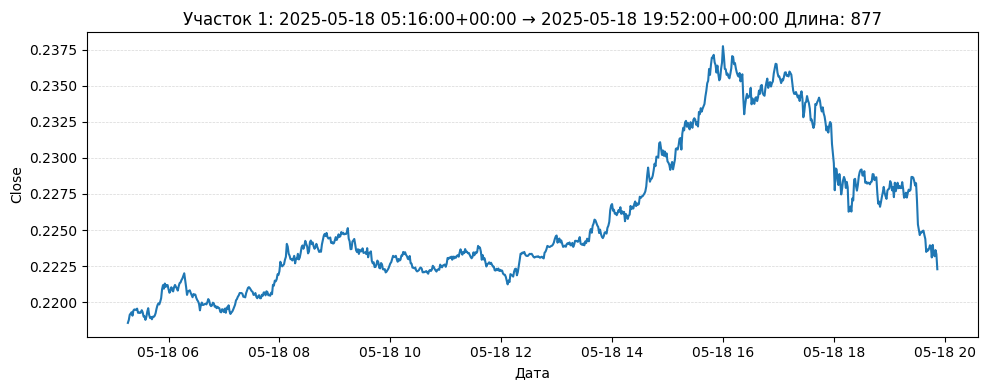

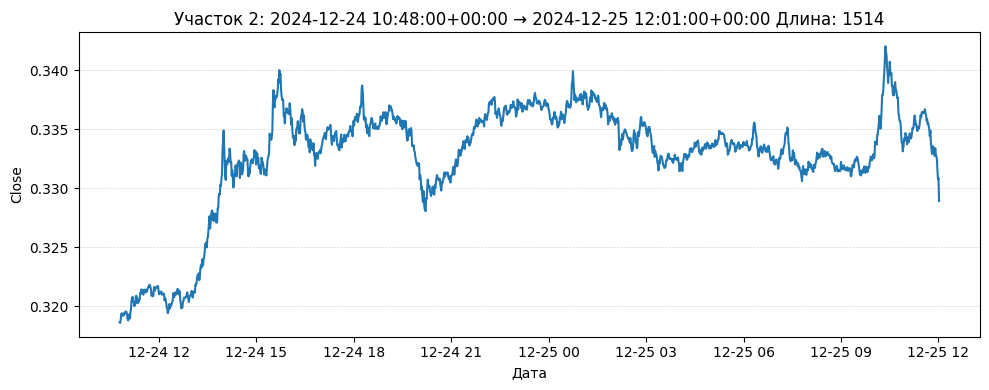

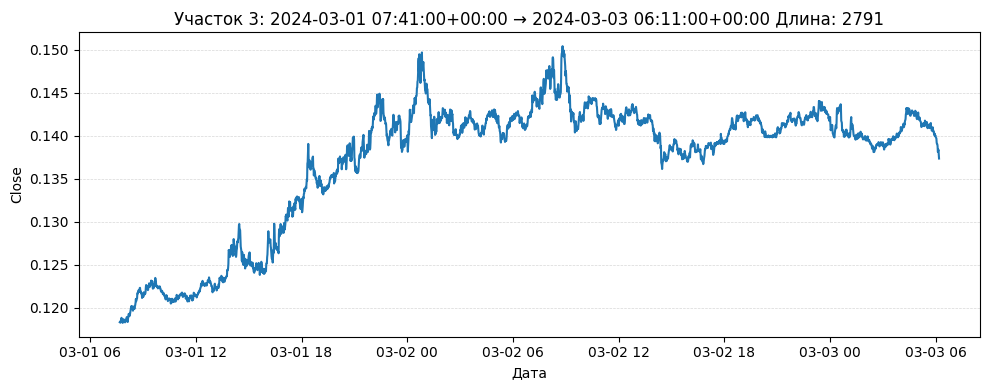

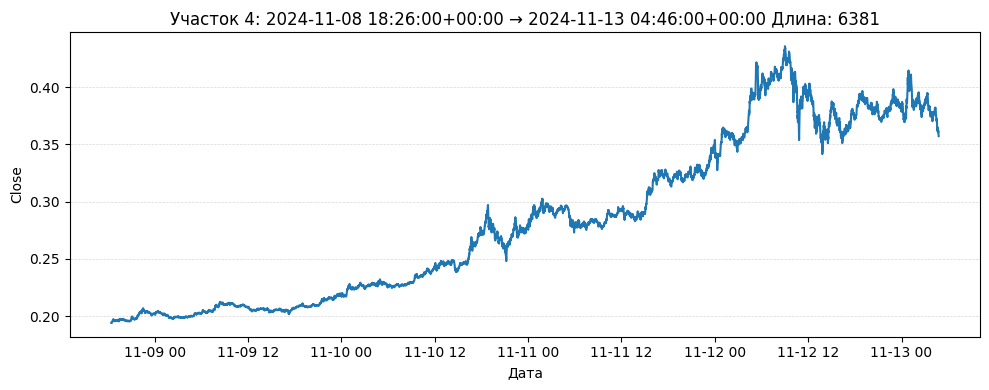

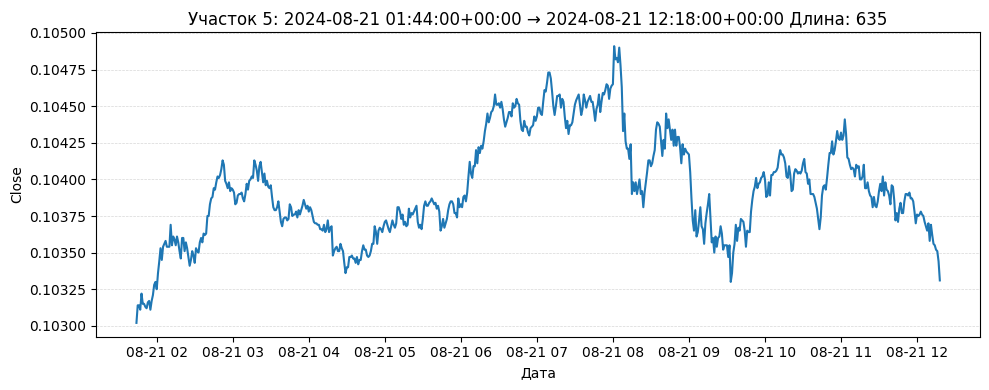

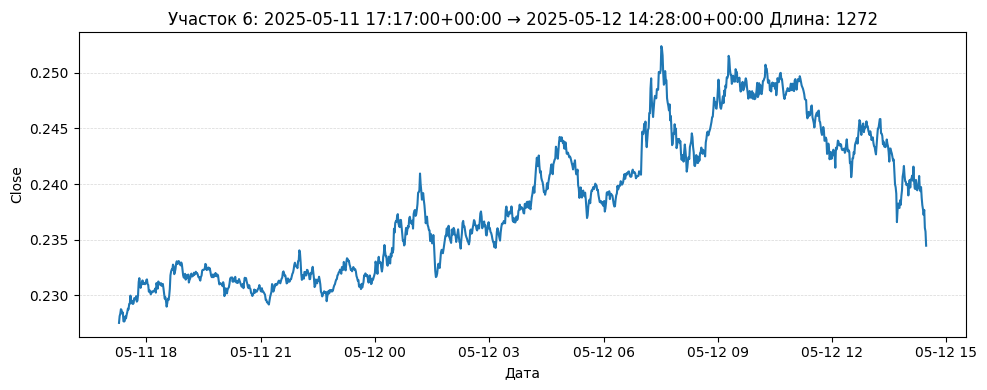

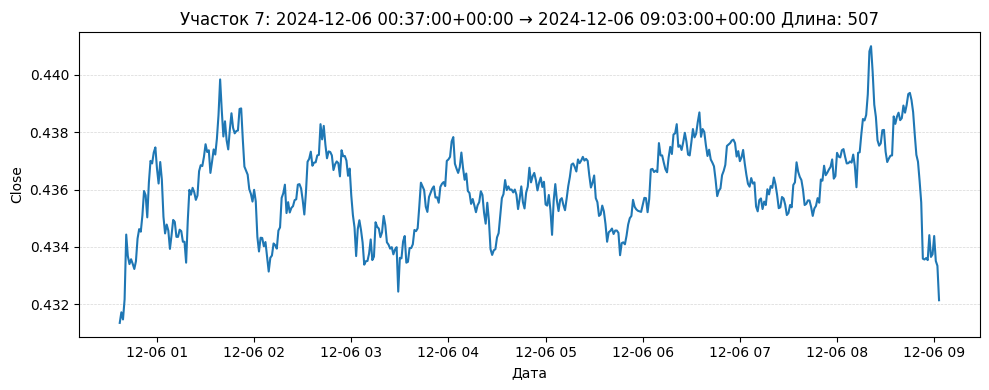

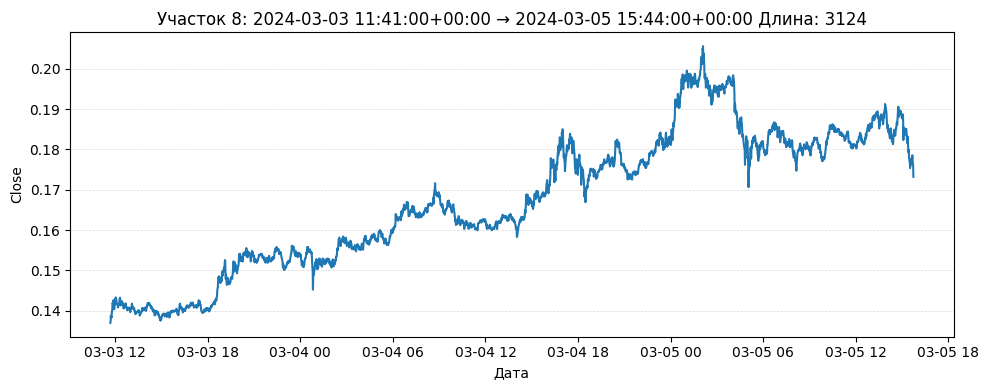

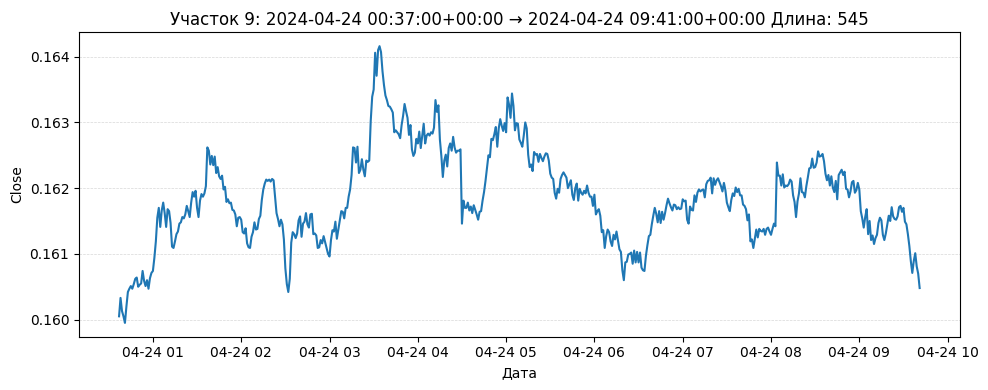

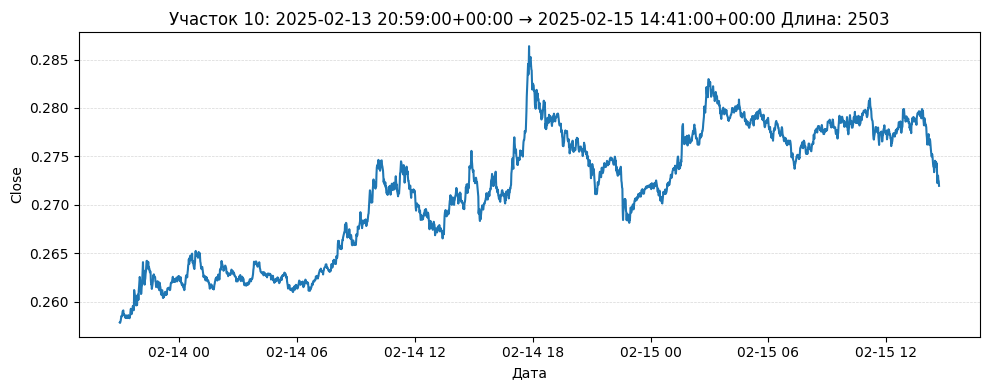

In [7]:
# @title Фильтрация датасета на трендовые участки
df['EMA_2500'] = ema_numba(close, 2500)

buy_sig  = (df['Close'] > df['EMA_2500'])
sell_sig = (df['Close'] < df['EMA_2500'])

df['Trend_filter'] = np.where(buy_sig, 1, np.where(sell_sig, -1, 0)).astype(np.int8)

# 1) Получаем список участков
segments = get_intervals(df, 'Trend_filter', threshold=500)  # список DatetimeIndex

# 2) Рисуем 5 случайных участков
plot_price_with_valid(df, 'Close', segments, n_plots=10, seed=42, assume_df_tz='UTC')



In [8]:
# @title Нормализация и нарезка данных
enriched = df.copy()
builder = DatasetBuilderForYourColumns(
    seq_len=SEQ_LEN, norm="minmax",
    labels_from="a", # change to "q" if use q-labels
    tau=1, r_mode="oracle",
    splits=SPLITS,
    batch_size=BATCH_SIZE,
    sw_mode="ClassBalance",
    feature_cols = FEATURES,
    account_cols = ACCOUNT_F,
    betta = 0.5 # процент сэмплов подлежащих удалению
)
splits = builder.fit_transform(enriched, return_indices=True, train_valid_indices=segments)
train_ds, val_ds, test_ds = builder.as_tf_datasets(splits)
test_idx = splits["test"][-1]

print("Train:", len(train_ds))
print("Val:", len(val_ds))
print("Test:", len(test_ds))

Train: 211
Val: 138
Test: 138


In [ ]:
# @title Оптимизация гиперпараметров (только для подбора)

xb, _ = next(iter(train_ds.take(1)))
feature_dim = xb.shape[-1]
best_params = optimize_hyperparameters(
    train_ds,
    val_ds,
    seq_len=SEQ_LEN,
    feature_dim=feature_dim,
    n_trials=10,
    epochs=5,
)

UNITS_PER_LAYER = best_params['units_per_layer']
DROPOUT = best_params['dropout']
LR = best_params['lr']

Epoch 01 | train: loss 0.5414, acc 0.7594, ER 0.000000 | val: loss 0.4911, acc 0.7761, macroF1 0.6489, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 02 | train: loss 0.5138, acc 0.7894, ER 0.000000 | val: loss 0.4736, acc 0.7791, macroF1 0.6559, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 03 | train: loss 0.4951, acc 0.8088, ER 0.000000 | val: loss 0.4689, acc 0.7823, macroF1 0.6620, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 04 | train: loss 0.4882, acc 0.8133, ER 0.000000 | val: loss 0.4735, acc 0.7851, macroF1 0.6649, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 05 | train: loss 0.4878, acc 0.8189, ER 0.000000 | val: loss 0.4613, acc 0.7885, macroF1 0.6675, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 06 | train: loss 0.4850, acc 0.8220, ER 0.000000 | val: loss 0.4763, acc 0.7828, macroF1 0.6625, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 07 | train: loss 0.4804, acc 0.8229, ER 0.000000 | val: loss 0.4692, acc 0.7872, macroF1 0.6656, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 08 | train: loss 0.47

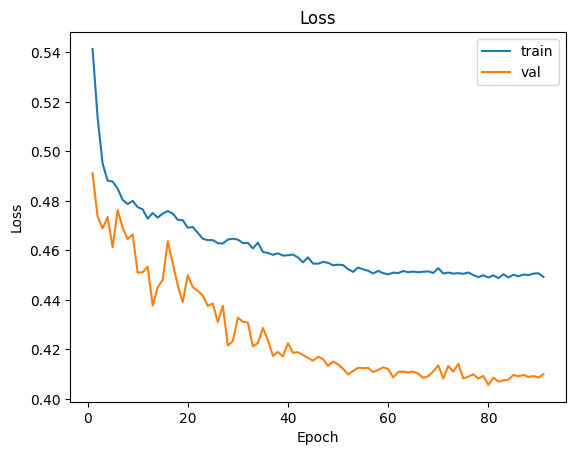

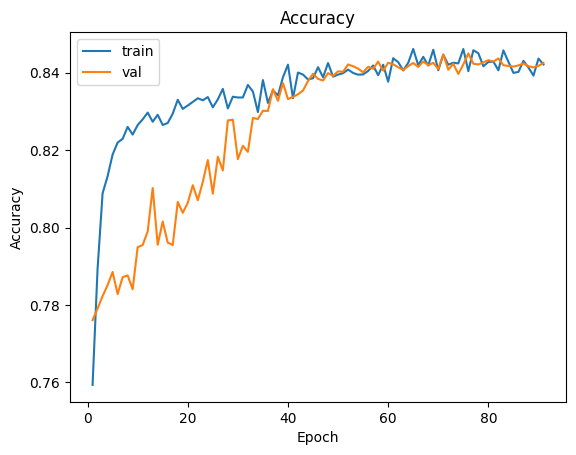

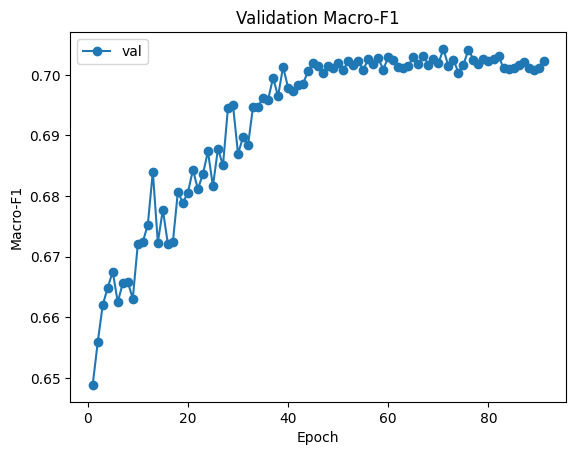

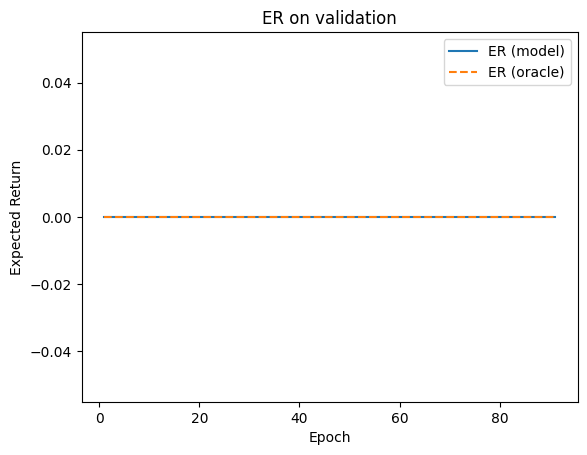

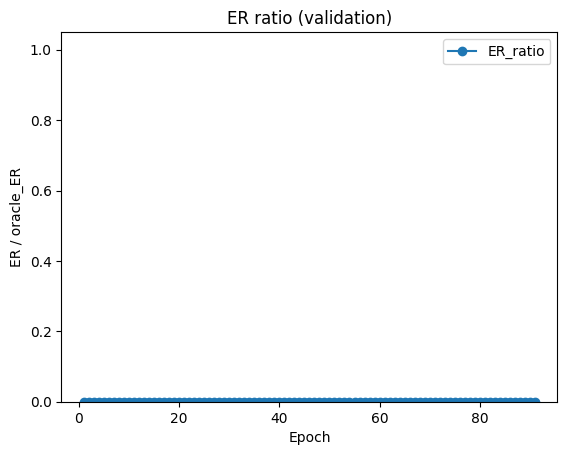

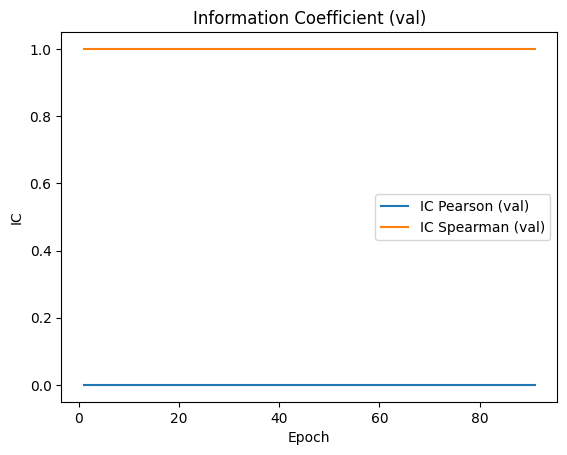

In [9]:
# @title Обучение модели
xb, _ = next(iter(train_ds.take(1)))
model = build_stacked_residual_lstm(seq_len=xb.shape[1],
                                    feature_dim=xb.shape[-1],
                                    units_per_layer=UNITS_PER_LAYER,
                                    dropout=DROPOUT)

history = fit_model(
    model,
    train_ds,
    val_ds,
    epochs=EPOCHS,
    steps_per_epoch=None,
    lr=LR,
    grad_clip_norm=GRAD_CLIP_NORM,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    lr_mode=LR_MODE,
    onecycle_max_lr=ONECYCLE_MAX_LR,
    onecycle_pct_start=ONECYCLE_PCT_START,
    lr_restart_patience=LR_RESTART_PATIENCE,
    lr_restart_shrink=LR_RESTART_SHRINK,
    best_weights_path=BEST_WEIGHTS_PATH,
    save_backbone=SAVE_BACKBONE,
)

plot_history_curves(history)

In [10]:
# 3) оценка на тесте
test_metrics = evaluate_dataset(model, test_ds)
print("TEST METRICS:")
for k,v in  materialize_metrics(test_metrics).items():
  print(f"{k}:{v}")

TEST METRICS:
loss:0.39612600207328796
acc:0.8411977291107178
macro_f1:0.6819314956665039
f1_per_class:[0.6035715937614441, 0.6028990149497986, 0.7141628265380859, 0.8070927262306213]
exp_return:0.0
oracle_ER:0.0
ER_ratio:0.0
IC_pearson:0.0
IC_spearman:1.0


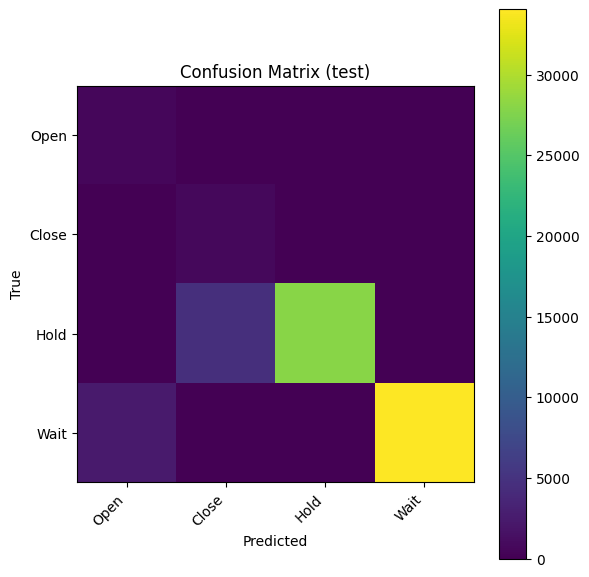

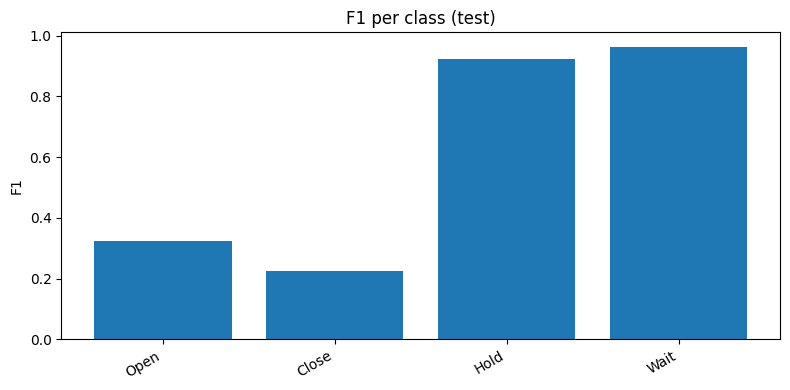

In [11]:
# 4) конфьюжн-матрица и F1 per class на тесте
cm_test, f1_test = confusion_and_f1_on_dataset(model, test_ds)

In [ ]:
# @title Loading model
model = build_stacked_residual_lstm(seq_len=SEQ_LEN,
                                    feature_dim=len(FEATURES) + len(ACCOUNT_F),
                                    units_per_layer=UNITS_PER_LAYER,
                                    dropout=DROPOUT)
model.load_weights("/content/drive/MyDrive/stocks/pretrained_rl_ppo/sl_weights/exp3/best_full_model_ep:51_f1:65.7.weights.h5")

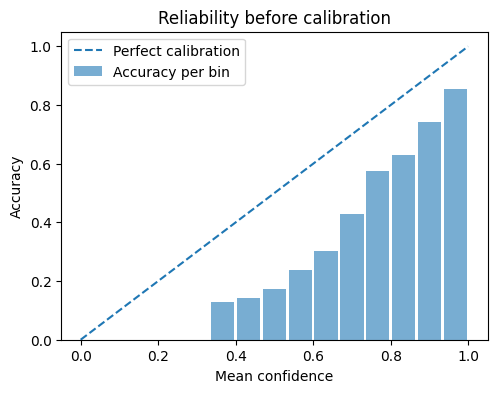

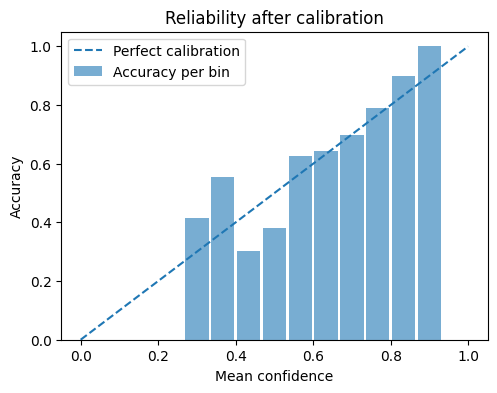

NLL before: 1.425707 | ECE before: 0.243360
NLL after:  1.229894 | ECE after:  0.092903
Temperature T: [3.7015674 1.6152841 1.2162564 1.5873549]
Saved: artifacts/calibration/temperature.json
Температуры:  [3.7015674114227295, 1.6152840852737427, 1.2162563800811768, 1.5873548984527588]


In [ ]:
# @title Калибровка модели
calib_info = calibrate_model(model, val_ds, per_class=True, init_T=1.0, plot=True)
T = calib_info['T']
print("Температуры: ", T)

In [ ]:
# @title Запуск бэктестов: референс стратегия, модель, учитель

def run_backtest_teacher(df, environment):
    env = environment
    env.reset()
    for a_row in df[['Q_Open', 'Q_Close', 'Q_Hold', 'Q_Wait']].iloc[:-1].to_numpy():
        mask = env.action_mask()
        a_row = np.where(mask > 0.0, a_row, 1e-9)
        a_row = a_row - np.max(a_row)
        a_row_exp = np.exp(a_row) * mask
        denom = a_row_exp.sum()
        Y = np.where(denom > 0.0, a_row_exp / np.maximum(denom, 1e-8), 1.0 / 4)
        action = np.argmax(Y)
        _, _, done, _ = env.step(action)

        if done:
            break
    return env

LONG_CONFIG = EnvConfig(
    mode=1,          # работаем только от длинной позиции
    fee=0.0002,         # без комиссии
    spread=0.0001,      # без спреда
    leverage=1.0,    # без плеча
    max_steps=10**9, # практически бесконечный эпизод
    reward_scale=1.0,# без масштабирования вознаграждения
    valid_time=0,
    use_log_reward=False, # линейная доходность
    time_penalty=0.0,     # нет штрафа за удержание
    hold_penalty=0.0,     # нет штрафа за бездействие
)

start, end = int(test_idx[0]), int(test_idx[-1])
df_bt = enriched.iloc[start:end+2].copy()

env_ref = BacktestEnv(df_bt, cfg=LONG_CONFIG, price_col='Open', ppo_true=False)
sim_ref = run_backtest(env_ref)

# env_tch = BacktestEnv(df_bt, cfg=LONG_CONFIG, price_col='Open')
# sim_tch = run_backtest_teacher(df_bt, env_tch)
# sim_tch.plot("teacher")
# print('Метрики учителя:')
# print(sim_tch.metrics_report())

def model_infer(inputs, training=False):
    logits = model(inputs, training=False)
    return logits / T if T is not None else logits

env_model = run_backtest_with_logits(
     enriched,
     model_infer,
     feature_stats=builder.stats_features,
     seq_len=SEQ_LEN,
     start=start,
     feature_cols=builder.feature_names,
     price_col='Open',
     cfg=LONG_CONFIG,
     q_threshold = None
)

env_model.plot("model")
print('\nМетрики модели:')
print(env_model.metrics_report())


log_ref = sim_ref.logs()
log_model = env_model.logs()
# log_teacher = sim_tch.logs()

plt.figure(figsize=(12,6))
plt.plot(log_ref['equity'], label='reference')
plt.plot(log_model['equity'], label='model')
# plt.plot(log_teacher['equity'], label='teacher')
plt.legend()
plt.title('Equity curves on test set')
plt.xlabel('step')
plt.ylabel('equity')
plt.show()

 46%|████▋     | 32767/70555 [08:30<09:56, 63.39it/s]